In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.utils import shuffle

from torch.autograd import Function, Variable
import torch
from torch import nn
import random

In [17]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend', fontsize=10)

width = 5
height = width/1.618

In [18]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [19]:
# Differentiable logistic regression in PyTorch
class LR(Function):
    @staticmethod
    def forward(ctx, X, y, C):
        # X is N by n
        # y is N by 1 of (-1, 1)
        N, n = X.shape
        y = y.squeeze()
        lr = LogisticRegression(C=C.item(), fit_intercept=True)
        lr.fit(X.data.numpy(), y.data.numpy())
        theta = Variable(torch.Tensor(np.concatenate([lr.coef_.flatten(), lr.intercept_])))
        X1 = torch.cat([X.clone(), Variable(torch.ones(N, 1))], dim=1)
        pi = 1./(1.+torch.exp(-y*(X1.mm(theta.unsqueeze(-1)).squeeze())))
        s1 = C*(pi-1)*y
        
        eye = torch.eye(n+1); eye[-1,-1] = 0. # no regularization on intercept
        s2 = torch.inverse(eye + C*X1.t().mm(torch.diag(pi*(1-pi)).mm(X1)))
        ctx.save_for_backward(s1, s2)
        ctx.N = N
        
        return theta
        
    @staticmethod
    def backward(ctx, grad_output):
        s1, s2 = ctx.saved_tensors
        s3 = grad_output.unsqueeze(0).mm(s2)
        s3 = s3.repeat([ctx.N,1])
        return -(s1.unsqueeze(-1)*s3)[:,:-1], None, None
    
lr = LR.apply

In [20]:
def class1():
    if random.random() < .5:
        return np.array([np.random.uniform(-1,.2),np.random.uniform(-.2,1)])
    else:
        return np.array([np.random.uniform(-.2,1.),np.random.uniform(-1,.2)])
def class2():
    if random.random() < .5:
        return np.array([np.random.uniform(-1,.2),np.random.uniform(-1.,.2)])
    else:
        return np.array([np.random.uniform(-.2,1.),np.random.uniform(-.2,1)])

In [21]:
def get_data(N):
    X = []
    for _ in range(N//2):
        X.append(class1()*3)
    for _ in range(N//2):
        X.append(class2()*3)
    X = np.array(X)
    y = np.r_[
        -np.ones(N//2),
        np.ones(N//2)
    ]
    return X,y

In [22]:
ntrain = 100
ntest = 1000
n = 2
X, y = get_data(ntrain)
Xt, yt = get_data(ntest)

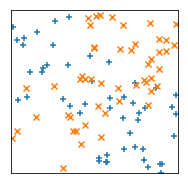

In [23]:
fig = plt.figure()
plt.scatter(X[:ntrain//2,0],X[:ntrain//2,1],marker='+')
plt.scatter(X[ntrain//2:,0],X[ntrain//2:,1],marker='x')
plt.xlim(-3,3)
plt.ylim(-3,3)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.set_size_inches(3,3)
plt.show()

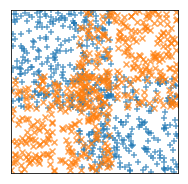

In [24]:
fig = plt.figure()
plt.scatter(Xt[:ntest//2,0],Xt[:ntest//2,1],marker='+',alpha=.7)
plt.scatter(Xt[ntest//2:,0],Xt[ntest//2:,1],marker='x',alpha=.7)
plt.xlim(-3,3)
plt.ylim(-3,3)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.set_size_inches(3,3)
plt.savefig('figures/xor/data-test.pdf')
plt.show()

In [25]:
X_train = Variable(torch.Tensor(X), requires_grad=False)
y_train = Variable(torch.Tensor(y), requires_grad=False)

Xtv = Variable(torch.Tensor(Xt), requires_grad=False)
ytv = Variable(torch.Tensor(yt), requires_grad=False)

In [26]:
# split into K random partitions
K = 256
f = .95
Xs_train = Variable(torch.zeros(K, int(ntrain*f), n))
ys_train = Variable(torch.zeros(K, int(ntrain*f)))
Xs_val = Variable(torch.zeros(K, ntrain-int(ntrain*f), n))
ys_val = Variable(torch.zeros(K, ntrain-int(ntrain*f)))

for i in range(K):
    indices = np.random.permutation(ntrain)
    
    training_idx, val_idx = indices[:int(ntrain*f)], indices[int(ntrain*f):]
    training_idx = torch.LongTensor(training_idx)
    val_idx = torch.LongTensor(val_idx)
    
    Xs_train[i] = X_train[training_idx]; ys_train[i] = y_train[training_idx]
    Xs_val[i] = X_train[val_idx]; ys_val[i] = y_train[val_idx]

In [27]:
C = Variable(torch.Tensor([50.]), requires_grad=False)
net = nn.Sequential(nn.Linear(X.shape[1], 64), nn.ReLU(), nn.Linear(64,64), nn.ReLU(), nn.Linear(64,X.shape[1]))
optimizer = torch.optim.SGD(net.parameters(), lr=.1)

0.704382598400116
0.524


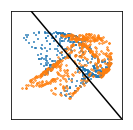

0.6960907578468323
0.538


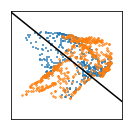

0.6814503073692322
0.557


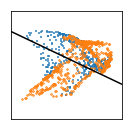

0.6548299789428711
0.57


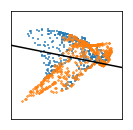

0.6082466244697571
0.582


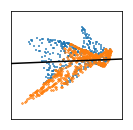

0.5305569171905518
0.677


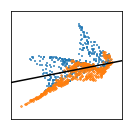

0.4314981698989868
0.698


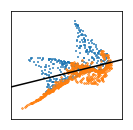

0.3910934329032898
0.699


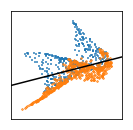

0.37833938002586365
0.704


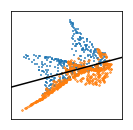

0.3677387833595276
0.705


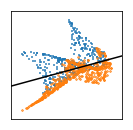

0.36283665895462036
0.707


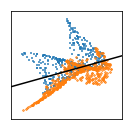

0.3583187162876129
0.71


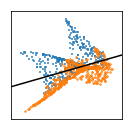

0.35534903407096863
0.71


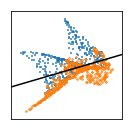

0.35251450538635254
0.71


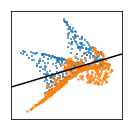

0.3500954806804657
0.71


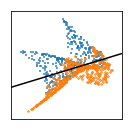

0.3480171263217926
0.71


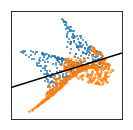

0.3461766839027405
0.71


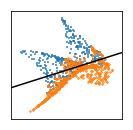

0.34456712007522583
0.712


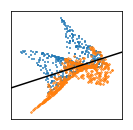

0.34313881397247314
0.712


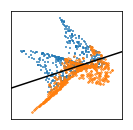

0.3418271243572235
0.71


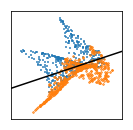

0.34056153893470764
0.711


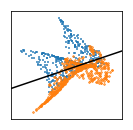

0.339276522397995
0.712


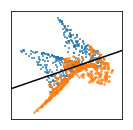

0.33802250027656555
0.713


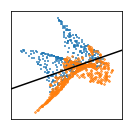

0.3368881046772003
0.715


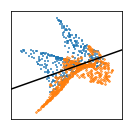

0.33583587408065796
0.717


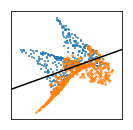

0.33483704924583435
0.717


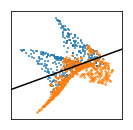

0.3338588774204254
0.717


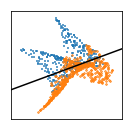

0.3328975439071655
0.717


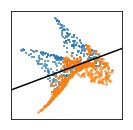

0.33196893334388733
0.716


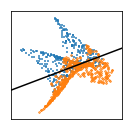

0.3310764729976654
0.716


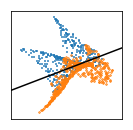

0.3302149176597595
0.716


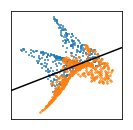

0.3293088674545288
0.717


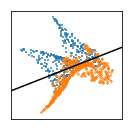

0.32847705483436584
0.717


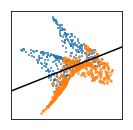

0.3276416063308716
0.719


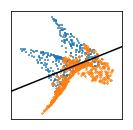

0.3267820477485657
0.72


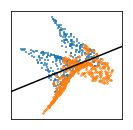

0.32602450251579285
0.72


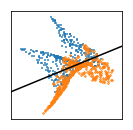

0.3252352178096771
0.72


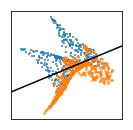

0.32451555132865906
0.72


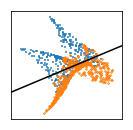

0.32379665970802307
0.72


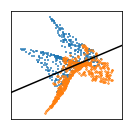

0.32308629155158997
0.721


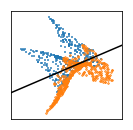

0.3225071430206299
0.721


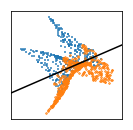

0.321842759847641
0.719


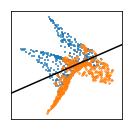

0.3212795853614807
0.719


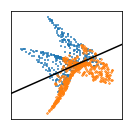

0.3206700086593628
0.718


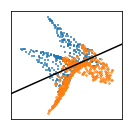

0.3200927674770355
0.718


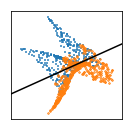

0.31949758529663086
0.718


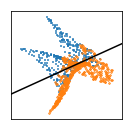

0.31891122460365295
0.717


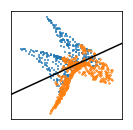

0.3183182179927826
0.717


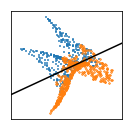

0.31775152683258057
0.717


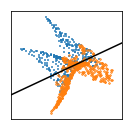

0.3172145187854767
0.716


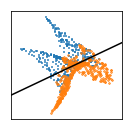

In [28]:
def closure():
    bce = torch.nn.BCEWithLogitsLoss()
    optimizer.zero_grad()
    loss = 0.
    for i in range(K):
        theta = lr(net(Xs_train[i]),ys_train[i],C)
        pi = torch.cat([net(Xs_val[i]).detach(), Variable(torch.ones(Xs_val[i].shape[0], 1))], dim=1).mm(theta.unsqueeze(-1))
        loss += torch.nn.SoftMarginLoss()(pi.squeeze(),ys_val[i])/K
    print (loss.item())
    loss.backward()
    return loss

for i in range(50):
#     if i % 1 == 0:
    optimizer.step(closure)
    theta = lr(net(X_train).detach(), y_train, C)
    pi =  torch.cat([net(Xtv).detach(), Variable(torch.ones(Xtv.shape[0], 1))], dim=1).mm(theta.unsqueeze(-1))
    print (((pi > 0).data.numpy().flatten() == (ytv.data.numpy().flatten() + 1.) / 2).mean())
    
    # plots
    Xtransformed = net(Xtv).data.numpy()
    fig = plt.figure()
    plt.scatter(Xtransformed[:500,0],Xtransformed[:500,1],marker='+',alpha=.7,s=3)
    plt.scatter(Xtransformed[500:,0],Xtransformed[500:,1],marker='x',alpha=.7,s=3)
    xlim = (np.min(Xtransformed[:,0])-.1,np.max(Xtransformed[:,0])+.1)
    ylim= (np.min(Xtransformed[:,1])-.1,np.max(Xtransformed[:,1])+.1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.set_size_inches(2,2)
    theta1,theta2,theta3 = theta[0].data.item(),theta[1].data.item(),theta[2].data.item()
    plt.plot([-5,5],[-theta1/theta2*(-5)-theta3/theta2,-theta1/theta2*(5)-theta3/theta2],c='black')
    plt.savefig('figures/xor/data-%d.pdf' % i)
    plt.show()
#     print (((torch.norm(Xtv,dim=1) > 1.5).data.numpy().flatten() == (ytv.data.numpy().flatten() + 1.) / 2).mean())

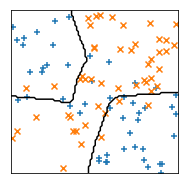

In [29]:
def decision(xy):
    xy = net(Variable(torch.Tensor(xy))).data.numpy().flatten()
    return theta[0].data.item()*xy[0] + theta[1].data.item()*xy[1] + theta[2].data.item() > 0
xx = np.linspace(-3,3,100)
yy = np.linspace(-3,3,100)
YY, XX = np.meshgrid(yy, xx)
Z = np.zeros(XX.shape)
for i in range(len(xx)):
    for j in range(len(yy)):
        Z[i,j] = decision([xx[i],yy[j]])

# plot decision boundary and margins
fig = plt.figure()
plt.scatter(X[:ntrain//2,0],X[:ntrain//2,1],marker='+')
plt.scatter(X[ntrain//2:,0],X[ntrain//2:,1],marker='x')
plt.xlim(-3,3)
plt.ylim(-3,3)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.set_size_inches(3,3)
plt.contour(XX, YY, Z, colors='black', levels=[0])
plt.savefig('figures/xor/data.pdf')
plt.show()

In [30]:
(np.logical_xor(Xt[:,0]>0,Xt[:,1]>0) != yt).mean()

0.851